In [1]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections
import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

In [2]:
DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [3]:
sessions = [session['session_id'] for session in client.list_sessions()['result']]

for i in range(len(sessions)):
    print(f"{i}: {sessions[i]}")

0: MNIST_GBP010_25R_19_01
1: MNIST_LFB_25R_16_04_V2
2: MNIST_LFB_25R_18_02_V2
3: MNIST_LFB_25R_19_01_V2
4: TEST_5_WITH_EPOCH_01
5: TEST_EPOCH_04
6: TEST_EPOCH_03
7: TEST_EPOCH_02
8: TEST_EPOCH_01
9: MNIST_GBM001_25R_18_02
10: MNIST_GBM001_25R_19_01
11: MNIST_BASE_25R_20_00


In [4]:
session_ids_to_analyze = [int(x) for x in input("Provide a the sessions to be analyzed, seperated by a space: ").split()]

Provide a the sessions to be analyzed, seperated by a space:  1 2 3 11


In [5]:
print("You chose the following sessions:")
[(num, session_id) for (num, session_id) in zip(session_ids_to_analyze, [sessions[i] for i in session_ids_to_analyze])]

You chose the following sessions:


[(1, 'MNIST_LFB_25R_16_04_V2'),
 (2, 'MNIST_LFB_25R_18_02_V2'),
 (3, 'MNIST_LFB_25R_19_01_V2'),
 (11, 'MNIST_BASE_25R_20_00')]

In [23]:
text = 'MNIST_LFB_25R_16_04_V2'
text[-8:-6]

'16'

In [6]:
model_sets = [client.list_models(session) for session in [sessions[i] for i in session_ids_to_analyze]]

In [7]:
[item['count'] for item in model_sets]

[25, 25, 25, 25]

In [8]:
# Check if round counts are same for all sessions
const_model_count = model_sets[0]['count']
for model_set in model_sets:
    if model_set['count'] != const_model_count:
        print("There is atleast one session which doesn't have the same model count")
        # Add code to terminate the script

In [9]:
for model_set in model_sets:
    model_set['result'].reverse()

In [10]:
# model_sets

In [11]:
# client.list_validations(modelId = '388a829d-f2db-42c5-9c3d-0c5278659999')

metrics = []

for model_set in model_sets:
    session_metrics = {
        "session_id": model_set['result'][0]['session_id'],
        "training_loss": [],
        "training_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }

    model_set_results = model_set['result']

    for model in model_set_results:
        validations = client.list_validations(modelId = model['model'])
        result_ids = [result_id for result_id in validations]
        training_losses = []
        training_accuracies = []
        test_losses = []
        test_accuracies = []
        
        for result_id in result_ids:
            training_losses.append(json.loads(validations[result_id]['data'])['training_loss'])
            training_accuracies.append(json.loads(validations[result_id]['data'])['training_accuracy'])
            test_losses.append(json.loads(validations[result_id]['data'])['test_loss'])
            test_accuracies.append(json.loads(validations[result_id]['data'])['test_accuracy'])

        session_metrics['training_loss'].append(np.mean(training_losses))
        session_metrics['training_accuracy'].append(np.mean(training_accuracies))
        session_metrics['test_loss'].append(np.mean(test_losses))
        session_metrics['test_accuracy'].append(np.mean(test_accuracies))

    metrics.append(session_metrics)

In [12]:
# metrics

In [13]:
# x = range(const_model_count)

# for experiment in metrics:
#     plt.plot(x, experiment['training_loss'])

# plt.legend([f"{int(int(metric['session_id'][-2:])*100/(int(metric['session_id'][-2:]) + int(metric['session_id'][-5:-3])))}% malicious" for metric in metrics])
# plt.title('Training Loss Comparison')
# plt.xlabel('# of Rounds')
# plt.ylabel('Training Loss')
# plt.grid(True, linestyle=':')
# plt.xticks(np.arange(0, len(x) + 1, 5))
# plt.show()

In [14]:
# x = range(const_model_count)

# for experiment in metrics:
#     plt.plot(x, experiment['test_loss'])

# plt.legend([f"{int(int(metric['session_id'][-2:])*100/(int(metric['session_id'][-2:]) + int(metric['session_id'][-5:-3])))}% malicious" for metric in metrics])
# plt.title('Test Loss Comparison')
# plt.xlabel('# of Rounds')
# plt.ylabel('Test Loss')
# plt.grid(True, linestyle=':')
# plt.xticks(np.arange(0, len(x) + 1, 5))
# plt.show()

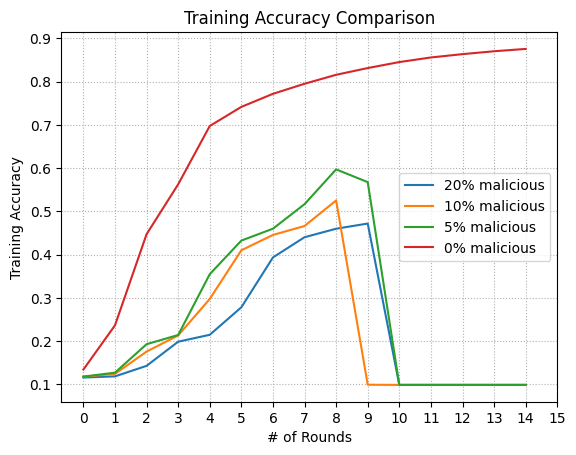

In [25]:
x = range(const_model_count)

for experiment in metrics:
    # plt.plot(x, experiment['training_accuracy'])
    plt.plot(x[:15], experiment['training_accuracy'][:15])

plt.legend(
    [
        f"{int(int(metric['session_id'][-2:])*100/(int(metric['session_id'][-2:]) + int(metric['session_id'][-5:-3])))}% malicious" 
        if metric['session_id'][-3:] != '_V2'
        else f"{int(int(metric['session_id'][-5:-3])*100/(int(metric['session_id'][-5:-3]) + int(metric['session_id'][-8:-6])))}% malicious"
        for metric in metrics
    ]
)
plt.title('Training Accuracy Comparison')
plt.xlabel('# of Rounds')
plt.ylabel('Training Accuracy')
plt.grid(True, linestyle=':')
# plt.xticks(np.arange(0, len(x) + 1, 5))
plt.xticks(np.arange(0, len(x[:15]) + 1, 1))
plt.show()

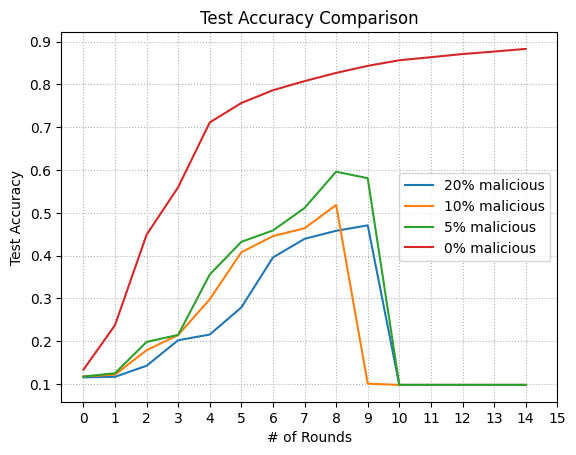

In [30]:
x = range(const_model_count)

for experiment in metrics:
    # plt.plot(x, experiment['test_accuracy'])
    plt.plot(x[:15], experiment['test_accuracy'][:15])

# plt.legend([f"{int(int(metric['session_id'][-2:])*100/(int(metric['session_id'][-2:]) + int(metric['session_id'][-5:-3])))}% malicious" for metric in metrics])
plt.legend(
    [
        f"{int(int(metric['session_id'][-2:])*100/(int(metric['session_id'][-2:]) + int(metric['session_id'][-5:-3])))}% malicious" 
        if metric['session_id'][-3:] != '_V2'
        else f"{int(int(metric['session_id'][-5:-3])*100/(int(metric['session_id'][-5:-3]) + int(metric['session_id'][-8:-6])))}% malicious"
        for metric in metrics
    ]
)
plt.title('Test Accuracy Comparison')
plt.xlabel('# of Rounds')
plt.ylabel('Test Accuracy')
plt.grid(True, linestyle=':')
# plt.xticks(np.arange(0, len(x) + 1, 5))
plt.xticks(np.arange(0, len(x[:15]) + 1, 1))
plt.show()